In [1]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization,Activation
from tensorflow.keras.optimizers import Adam


In [2]:
from google.colab import files
files.upload()  # select kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aymengnaoui","key":"ab181852c88d0a5447c48986a785a18e"}'}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition



 98% 794M/814M [00:05<00:00, 226MB/s]
100% 814M/814M [00:05<00:00, 167MB/s]


In [6]:
!unzip dogs-vs-cats-redux-kernels-edition.zip -d dataset/

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: dataset/sample_submission.csv  
  inflating: dataset/test.zip        
  inflating: dataset/train.zip       


In [ ]:
!unzip /content/dataset/train.zip -d /content/dataset/train/
!unzip /content/dataset/test.zip -d /content/dataset/test/


In [8]:
!mkdir -p /content/dataset/train/cats
!mkdir -p /content/dataset/train/dogs

!mv /content/dataset/train/train/cat.*.jpg /content/dataset/train/cats/
!mv /content/dataset/train/train/dog.*.jpg /content/dataset/train/dogs/


In [ ]:
!ls /content/dataset/train/cats | head
!ls /content/dataset/train/dogs | head


In [10]:
!rmdir /content/dataset/train/train


In [11]:
!ls dataset/ #test dataset

sample_submission.csv  test  test.zip  train  train.zip


In [12]:
# List all test image filenames and sort them
test_folder = '/content/dataset/test/test/'
filenames = os.listdir(test_folder)
filenames.sort()  # ensures 1.jpg, 2.jpg, ... 12500.jpg order

# Create DataFrame for the generator
test_df = pd.DataFrame({'filename': filenames})

In [13]:
#data preprocessing
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=15,           # ±15° rotation
                                   width_shift_range=0.1,       # ±10% horizontal shift
                                   zoom_range=0.1,              # ±10% zoom
                                   horizontal_flip=True,        # Mirror images (safe for animals)
                                   validation_split=0.2         # 20% for validation
                                   )
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                  directory='/content/dataset/train',
                  target_size =(100, 100),  # target_size = input image size
                  batch_size = 32,
                  class_mode ='binary',
                  subset='training')

validation_generator = train_datagen.flow_from_directory(
                  directory='/content/dataset/train',
                  target_size =(100, 100),
                  batch_size = 32,
                  class_mode ='binary',
                  subset='validation')


test_generator = test_datagen.flow_from_dataframe(
                    dataframe=test_df,
                    directory='/content/dataset/test/test',
                    x_col='filename',
                    target_size =(100, 100),
                    batch_size = 32,
                    class_mode =None,
                    shuffle=False
                    )

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 validated image filenames.


In [14]:
#building model
import random
options={
    "filters_per_layer_sets" : [[64, 128, 256],[64,128,256,512]],
    'dense_units': [256, 512],
    'learning_rate': [1e-3, 7.5e-4],
    'L2_weight': [0.01, 0.005]
}

def select_hyper_par(options):
    set_of_filters = random.choice(options["filters_per_layer_sets"])
    dense_units=random.choice(options["dense_units"])
    learning_rate=random.choice(options["learning_rate"])
    L2_weight=random.choice(options["L2_weight"])

    return{
        "num_of_conv_layers":len(set_of_filters),
        "filters_per_layer":set_of_filters,
        'dense_units': dense_units,
        'learning_rate': learning_rate,
        'L2_weight':L2_weight
    }

def build_model(options):
    model = Sequential()

    filters=options["filters_per_layer"]
    dense_units=options["dense_units"]
    learning_rate=options["learning_rate"]
    L2_weight=options["L2_weight"]

    for i,f in enumerate(filters):
        if i == 0:
            model.add(Conv2D(f,(3,3), input_shape=(100, 100, 3)))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
        else:
            model.add(Conv2D(f,(3,3)))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(dense_units))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid',kernel_regularizer =tf.keras.regularizers.l2(L2_weight)))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:

# we test multiple model using validation_generator
search_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.8  # Use 20% of data for search
)

# Small subset
search_generator = search_datagen.flow_from_directory(
    directory='/content/dataset/train',
    target_size=(100, 100),
    batch_size=32,
    class_mode='binary',
    subset='training',
    seed=42
)
def Random_search(n_iter):
    best_score = 0
    best_params = None

    for i in range(n_iter):
        params=select_hyper_par(options)
        model = build_model(params)
        history = model.fit(
                    search_generator,
                    steps_per_epoch = 40, #num_train_samples // batch_size
                    epochs = 10,
                    validation_data = validation_generator,
                    validation_steps=20,
                    verbose=0,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])
        # Mandatory reset
        search_generator.reset()
        validation_generator.reset()

        val_acc = max(history.history['val_accuracy'])
        val_loss = min(history.history['val_loss'])

        # Better scoring metric (higher is better)
        score = val_acc / (1 + val_loss)

        if i == 0 or score > best_score:
            best_score = score
            best_params = params
    return best_params,best_score
params,best_score = Random_search(20)
print(params)
print(best_score)


In [16]:
#best params after multiple random search
best_params = {'num_of_conv_layers': 4, 'filters_per_layer': [64, 128, 256, 512], 'dense_units': 512, 'learning_rate': 0.001, 'L2_weight': 0.01}

In [19]:

# Your compiled model being trained with fit_generator
model = build_model(best_params)
history = model.fit(
             train_generator,
             steps_per_epoch = len(train_generator), #num_train_samples // batch_size
             epochs = 30,
             validation_data = validation_generator,
             validation_steps = len(validation_generator), #num_validation_samples // batch_size
             callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 119s 173ms/step - accuracy: 0.6506 - loss: 0.6889 - val_accuracy: 0.7530 - val_loss: 0.5219
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 169ms/step - accuracy: 0.7866 - loss: 0.4598 - val_accuracy: 0.7776 - val_loss: 0.4672
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 105s 169ms/step - accuracy: 0.8250 - loss: 0.3947 - val_accuracy: 0.6878 - val_loss: 0.6922
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 105s 167ms/step - accuracy: 0.8540 - loss: 0.3342 - val_accuracy: 0.8326 - val_loss: 0.3806
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 168ms/step - accuracy: 0.8691 - loss: 0.3043 - val_accuracy: 0.7832 - val_loss: 0.5065
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 167ms/step - accuracy: 0.8887 - loss: 0.2708 - val_accuracy: 0.8448 - val_loss: 0.3506
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 162ms/step - accuracy: 0.8976 - loss: 0.2476 - val_accuracy: 0.8900 - val_loss: 0.2606
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 102s 164ms/step - accuracy: 0.9060 -

In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 98, 98, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 98, 98, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 47, 47, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 47, 47, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 47, 47, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 21, 21, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 21, 21, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 17,250,693 (65.81 MB)

 Trainable params: 5,749,249 (21.93 MB)

 Non-trainable params: 2,944 (11.50 KB)

 Optimizer params: 11,498,500 (43.86 MB)

In [21]:
# Get raw probabilities for kaggle (because submissions are scored on the log loss)
predictions = model.predict(test_generator, steps=len(test_generator)).flatten()


391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step


In [ ]:
predicted_classes = (predictions > 0.5).astype(int)


In [22]:

# Add predictions to DataFrame
test_df['id'] = test_df['filename'].str.replace('.jpg', '').astype(int)
test_df['label'] = predictions

# Create final submission DataFrame and save CSV
submission_df = test_df[['id', 'label']].sort_values('id')  # ensure it's in correct id order
submission_df.to_csv('final_submission.csv', index=False)

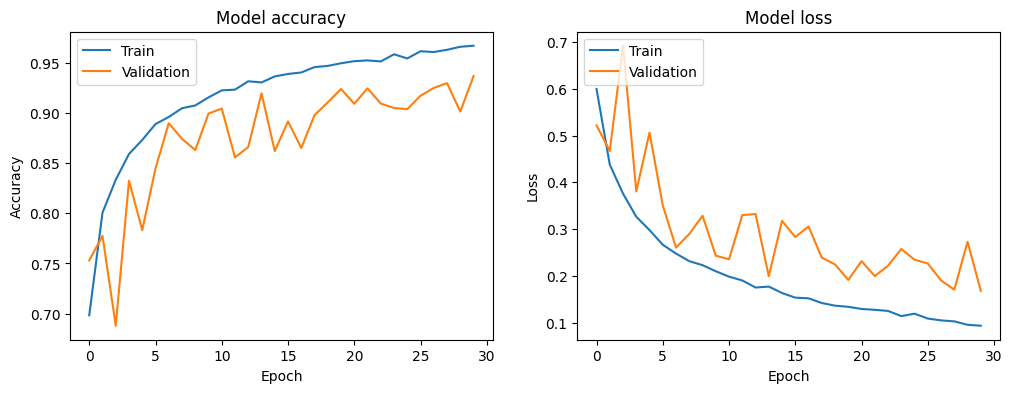

In [23]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

In [28]:
#save the weight of our model
model.save_weights('model.weights.h5')

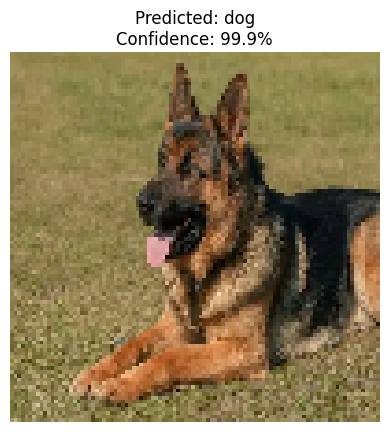


Prediction Result:
- Class: dog
- Confidence: 99.9%
- Raw Probability: 0.9986



In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

def predict_single_image(img_path, model):

    # 1. Load and preprocess image (matches your training)
    img = load_img(img_path, target_size=(100, 100))
    img_array = img_to_array(img)
    img_array = img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    # 2. Predict and interpret
    pred_prob = model.predict(img_batch, verbose=0)[0][0]

    # 3. Class mapping
    class_mapping = {0: 'cat', 1: 'dog'}
    predicted_class = class_mapping[int(pred_prob > 0.5)]
    confidence = max(pred_prob, 1 - pred_prob)  # Always show highest confidence

    # 4. Display results
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.1%}")
    plt.show()

    return {
        'class': predicted_class,
        'confidence': float(confidence),
        'probability': float(pred_prob if predicted_class == 'dog' else 1 - pred_prob)
    }

# Usage:
result = predict_single_image('/content/test_img_dog.webp', model)
print(f"""
Prediction Results :
- Class: {result['class']}
- Confidence: {result['confidence']:.1%}
- Raw Probability: {result['probability']:.4f}
""")